In [2]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [12]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 1
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = '12layers_leakyr_mse'

# Network and optimizer

In [13]:
model = net.AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:1


AutoEncoder(
  (enc1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_ru

# Data Loader & Dataset

In [14]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [15]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [16]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [17]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [18]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [19]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [20]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|███████████████████████████████████████| 1219/1219 [04:02<00:00,  5.02it/s]


Epoch: 1 	Training Loss: 0.032528 	Val Loss: 0.019166	     in time 4.109300m


100%|███████████████████████████████████████| 1219/1219 [04:16<00:00,  4.75it/s]


Epoch: 2 	Training Loss: 0.015953 	Val Loss: 0.012862	     in time 4.336863m


100%|███████████████████████████████████████| 1219/1219 [04:30<00:00,  4.50it/s]


Epoch: 3 	Training Loss: 0.011409 	Val Loss: 0.009814	     in time 4.576293m


100%|███████████████████████████████████████| 1219/1219 [05:37<00:00,  3.61it/s]


Epoch: 4 	Training Loss: 0.008963 	Val Loss: 0.007954	     in time 5.698669m


100%|███████████████████████████████████████| 1219/1219 [05:58<00:00,  3.40it/s]


Epoch: 5 	Training Loss: 0.007551 	Val Loss: 0.006978	     in time 6.051767m


100%|███████████████████████████████████████| 1219/1219 [06:04<00:00,  3.34it/s]


Epoch: 6 	Training Loss: 0.006770 	Val Loss: 0.006439	     in time 6.153039m


100%|███████████████████████████████████████| 1219/1219 [06:05<00:00,  3.33it/s]


Epoch: 7 	Training Loss: 0.006262 	Val Loss: 0.006022	     in time 6.164154m


100%|███████████████████████████████████████| 1219/1219 [06:08<00:00,  3.31it/s]


Epoch: 8 	Training Loss: 0.005884 	Val Loss: 0.005717	     in time 6.214770m


100%|███████████████████████████████████████| 1219/1219 [06:12<00:00,  3.27it/s]


Epoch: 9 	Training Loss: 0.005621 	Val Loss: 0.005509	     in time 6.283653m


100%|███████████████████████████████████████| 1219/1219 [06:12<00:00,  3.27it/s]


Epoch: 10 	Training Loss: 0.005412 	Val Loss: 0.005333	     in time 6.278979m


100%|███████████████████████████████████████| 1219/1219 [06:13<00:00,  3.27it/s]


Epoch: 11 	Training Loss: 0.005245 	Val Loss: 0.005186	     in time 6.294441m


100%|███████████████████████████████████████| 1219/1219 [06:17<00:00,  3.23it/s]


Epoch: 12 	Training Loss: 0.005101 	Val Loss: 0.005066	     in time 6.357000m


100%|███████████████████████████████████████| 1219/1219 [06:19<00:00,  3.21it/s]


Epoch: 13 	Training Loss: 0.004989 	Val Loss: 0.004961	     in time 6.391205m


100%|███████████████████████████████████████| 1219/1219 [06:16<00:00,  3.24it/s]


Epoch: 14 	Training Loss: 0.004894 	Val Loss: 0.004867	     in time 6.342417m


100%|███████████████████████████████████████| 1219/1219 [05:28<00:00,  3.72it/s]


Epoch: 15 	Training Loss: 0.004810 	Val Loss: 0.004777	     in time 5.528445m


100%|███████████████████████████████████████| 1219/1219 [04:22<00:00,  4.64it/s]


Epoch: 16 	Training Loss: 0.004743 	Val Loss: 0.004716	     in time 4.433562m


100%|███████████████████████████████████████| 1219/1219 [04:17<00:00,  4.74it/s]


Epoch: 17 	Training Loss: 0.004674 	Val Loss: 0.004642	     in time 4.344229m


100%|███████████████████████████████████████| 1219/1219 [04:16<00:00,  4.76it/s]


Epoch: 18 	Training Loss: 0.004613 	Val Loss: 0.004571	     in time 4.329998m


100%|███████████████████████████████████████| 1219/1219 [04:02<00:00,  5.04it/s]


Epoch: 19 	Training Loss: 0.004557 	Val Loss: 0.004519	     in time 4.091765m


100%|███████████████████████████████████████| 1219/1219 [04:01<00:00,  5.04it/s]


Epoch: 20 	Training Loss: 0.004504 	Val Loss: 0.004458	     in time 4.087194m
CPU times: user 1h 25min 17s, sys: 26min 5s, total: 1h 51min 23s
Wall time: 1h 48min 4s


# Results

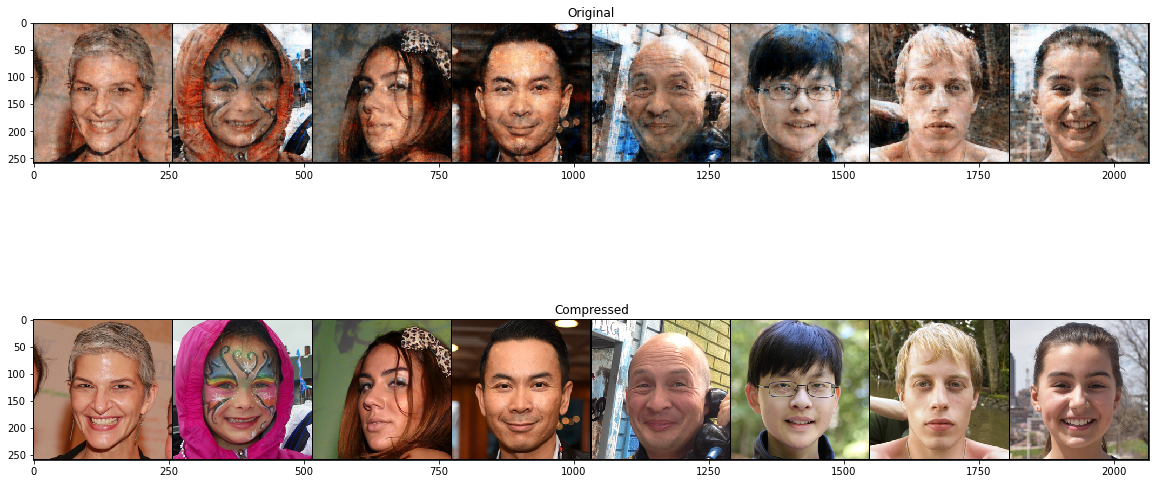

In [21]:
utils.show(val_true_grid, val_pred_grid)

In [22]:
path = Path("results") / RUN_NAME

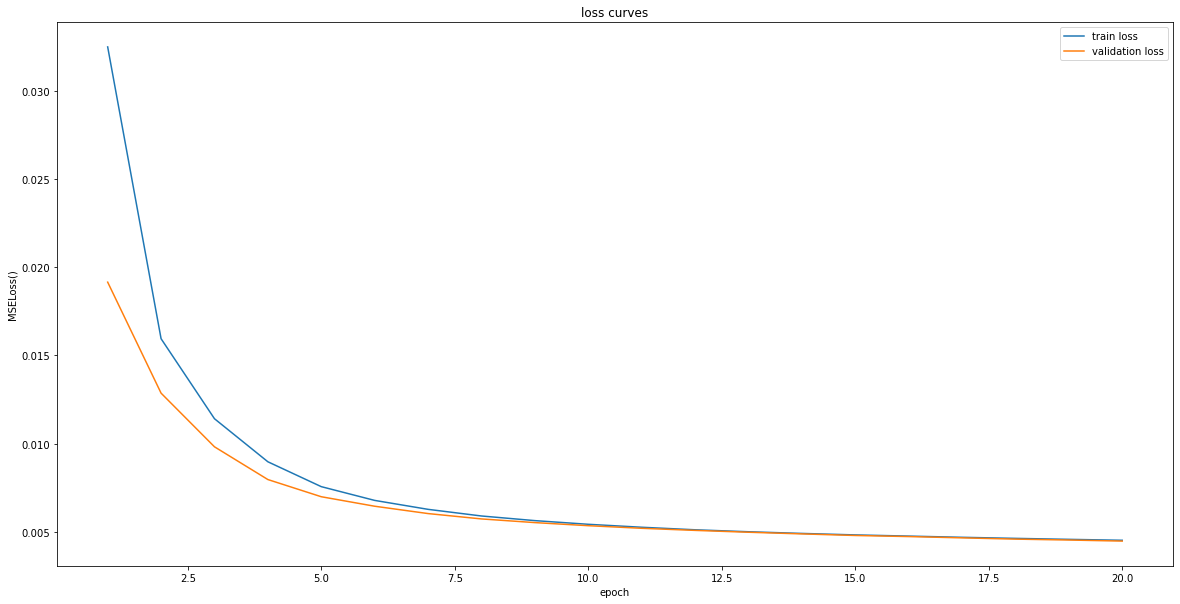

In [23]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [24]:
utils.write_losses(path, train_losses, val_losses)

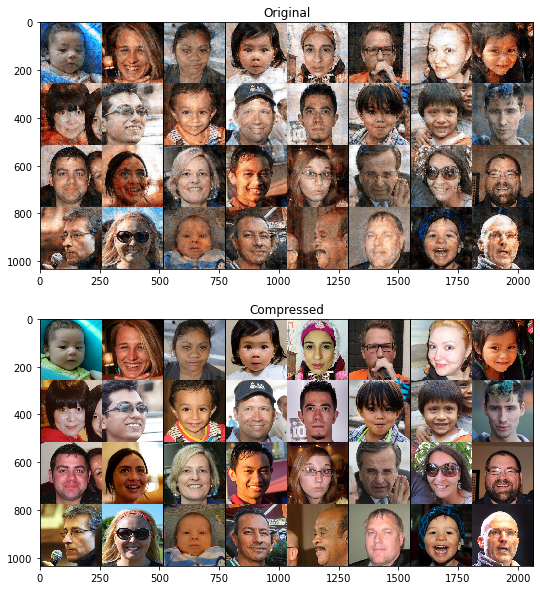

In [25]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)